In [2]:
# Data loading and preprocessing (example using librosa)
import librosa
import numpy as np
import os

# Define a dictionary to map species to class labels
species_to_label = {
    "Falco_cenchroides": 0,
    "Dasyornis_broadbenti": 1,
    "Chlamydera_nuchalis": 2,
    "Chenonetta_jubata": 3,
    "Charadrius_ruficapillus": 4
}

# Define a function to load and preprocess audio files
def load_and_preprocess_audio(file_path, target_length=16000):
    audio, _ = librosa.load(file_path, sr=target_length, mono=True)
    
    # Ensure all audio clips have the same length
    if len(audio) < target_length:
        # Pad the audio clip with zeros if it's shorter than the target length
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        # Truncate the audio clip if it's longer than the target length
        audio = audio[:target_length]

    return audio

# Load and preprocess your audio data and create labels
audio_data = []
labels = []

# Specify the directory containing audio files for each species
data_directory = "Data"

for species in species_to_label:
    species_directory = os.path.join(data_directory, species)
    for filename in os.listdir(species_directory):
        file_path = os.path.join(species_directory, filename)
        audio = load_and_preprocess_audio(file_path)
        audio_data.append(audio)
        labels.append(species_to_label[species])

# Convert data and labels to numpy arrays
audio_data = np.array(audio_data)
labels = np.array(labels)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the target length for audio clips (adjust as needed)
target_length = 16000  # You can change this to the desired audio clip length

# Define hyperparameters
num_epochs = 50  # Adjust the number of epochs as needed
batch_size = 32  # Adjust the batch size as needed

# Define a function to compute the Mel spectrogram
def compute_mel_spectrogram(x):
    # Apply Short-Time Fourier Transform (STFT)
    stft = tf.signal.stft(x, frame_length=1024, frame_step=512, fft_length=1024)
    
    # Convert to magnitude spectrogram
    magnitude = tf.abs(stft)
    
    # Create a Mel filterbank
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128, num_spectrogram_bins=magnitude.shape[-1],
        sample_rate=16000, lower_edge_hertz=0.0, upper_edge_hertz=8000.0)
    
    # Apply the filterbank to the magnitude spectrogram
    mel_spectrogram = tf.matmul(tf.square(magnitude), mel_filterbank)
    
    # Logarithmic scaling
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    
    return mel_spectrogram

# Define the model
model = models.Sequential([
    layers.Input(shape=(target_length,)),  # Adjust the input shape based on target_length
    layers.Reshape((128, -1, 1)),  # Reshape the Mel spectrogram
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Five classes for the five species
])


from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Example: Assuming you have labels as integers (0, 1, 2, 3, 4)
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(integer_encoded_labels)

# Now, one_hot_labels is a one-hot encoded representation of your labels


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical_crossentropy for one-hot encoded labels
              metrics=['accuracy'])

# Train the model
model.fit(audio_data, one_hot_labels, epochs=num_epochs, batch_size=batch_size)

# Save model
model.save('Model1')

2023-09-21 20:58:03.249091: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-09-21 20:58:03.249110: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-21 20:58:03.249117: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-21 20:58:03.249600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-21 20:58:03.249866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2023-09-21 20:58:03.817725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 76ms/step - loss: 2.9451 - accuracy: 0.5278
Epoch 2/50
6/6 [==============================] - 0s 39ms/step - loss: 1.4570 - accuracy: 0.6000
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 1.1648 - accuracy: 0.6222
Epoch 4/50
6/6 [==============================] - 0s 36ms/step - loss: 1.1740 - accuracy: 0.5833
Epoch 5/50
6/6 [==============================] - 0s 36ms/step - loss: 1.1043 - accuracy: 0.6167
Epoch 6/50
6/6 [==============================] - 0s 36ms/step - loss: 1.0558 - accuracy: 0.6611
Epoch 7/50
6/6 [==============================] - 0s 39ms/step - loss: 1.0067 - accuracy: 0.6944
Epoch 8/50
6/6 [==============================] - 0s 43ms/step - loss: 0.9435 - accuracy: 0.7167
Epoch 9/50
6/6 [==============================] - 0s 42ms/step - loss: 0.8659 - accuracy: 0.7167
Epoch 10/50
6/6 [==============================] - 0s 36ms/step - loss: 0.7678 - accuracy: 0.7500
Epoch 11/50
6/6 [=======================

INFO:tensorflow:Assets written to: Model1/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 125, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 123, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 61, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 245952)            0         
                                                                 
 dense (Dense)               (None, 128)               31481984  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 125, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 123, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 61, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 245952)            0         
                                                                 
 dense (Dense)               (None, 128)               31481984  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

6/6 [==============================] - 0s 30ms/step


2023-09-21 20:58:34.852336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 20ms/step


2023-09-21 20:58:35.127329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*** [[0.9902249  0.99180025 0.98868096 ... 0.9940749  0.99315494 0.9892255 ]
 [0.99369234 0.99153423 0.99205154 ... 0.9934372  0.9939822  0.99283135]
 [0.98836344 0.992459   0.9854004  ... 0.9882297  0.98473126 0.9821642 ]
 ...
 [0.99085367 0.9802605  0.9801619  ... 0.986762   0.98695165 0.9860772 ]
 [0.985284   0.9851494  0.9801792  ... 0.9804865  0.9782358  0.9722335 ]
 [0.98142886 0.98185617 0.979599   ... 0.97739536 0.9775388  0.97531486]] ***


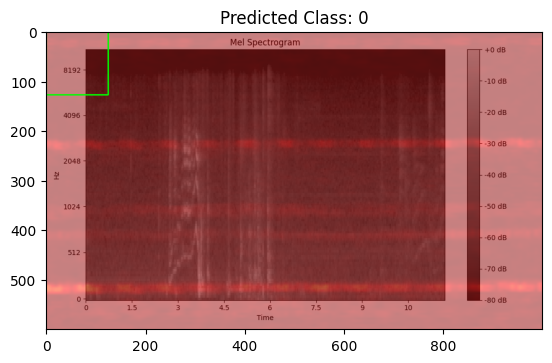

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('Model1')

# Load and preprocess your mel spectrogram image
mel_spectrogram = cv2.imread('ms2.png', cv2.IMREAD_GRAYSCALE)
#mel_spectrogram = cv2.resize(mel_spectrogram, (125, 128))  # Adjust dimensions to match your model

input_width = 125
input_height = 128

# Expand dimensions to match the model's input shape (if necessary)
mel_spectrogram = np.expand_dims(mel_spectrogram, axis=-1)


#from scipy.signal import resample

# Assuming mel_spectrogram has shape (525, 801, 1)
#resized_mel_spectrogram = resample(mel_spectrogram, 16000, axis=1)

# Perform inference
#predictions = model.predict(np.expand_dims(mel_spectrogram, axis=0))
#predictions = model.predict(np.expand_dims(resized_mel_spectrogram, axis=0))
predictions = model.predict(audio_data)

# Get the class index with the highest probability
predicted_class = np.argmax(predictions)

# Get the output of the final convolutional layer in your model
# Replace 'conv_layer_name' with the name of your model's last convolutional layer
activation_model = Model(inputs=model.input, outputs=model.get_layer('conv2d').output)
#activation = activation_model.predict(np.expand_dims(mel_spectrogram, axis=0))

activation = activation_model.predict(audio_data)

# Find the actual number of classes based on the model's output shape
num_classes = model.layers[-1].output_shape[1]

# Compute the class index with the highest probability
predicted_class = np.argmax(predictions, axis=1)

# Ensure that predicted_class is within the valid range of class indices
predicted_class = np.clip(predicted_class, 0, num_classes - 1)

predicted_class = int(predicted_class[0])

# Compute the class activation map (CAM) for the predicted class
class_weights = model.layers[-1].get_weights()[0]

class_weights = np.expand_dims(class_weights, axis=0)

class_weights = np.reshape(class_weights, (1, 640))

#cam = np.dot(activation, class_weights[:, predicted_class])

cam = np.sum(activation * class_weights[:, predicted_class], axis=3)

# Normalize the CAM
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

# Resize the CAM to match the mel spectrogram dimensions
cam = cv2.resize(cam[0], (input_width, input_height))

mel_spectrogram = cv2.cvtColor(mel_spectrogram, cv2.COLOR_GRAY2BGR)

# Apply a heatmap color map to visualize CAM
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

# Overlay the CAM on the mel spectrogram image
#alpha = 0.5  # Adjust transparency
#output_image = cv2.addWeighted(cv2.cvtColor(mel_spectrogram, cv2.COLOR_GRAY2BGR), alpha, heatmap, 1 - alpha, 0)

# Convert the mel_spectrogram to a 3-channel image
if mel_spectrogram.shape[-1] == 1:
    mel_spectrogram = cv2.cvtColor(mel_spectrogram, cv2.COLOR_GRAY2BGR)

# Resize the heatmap to match the dimensions of the mel spectrogram
heatmap_resized = cv2.resize(heatmap, (mel_spectrogram.shape[1], mel_spectrogram.shape[0]))

# Overlay the CAM on the mel spectrogram image
alpha = 0.5  # Adjust transparency
output_image = cv2.addWeighted(mel_spectrogram, alpha, heatmap_resized, 1 - alpha, 0)

# Overlay the CAM on the mel spectrogram image
#output_image = cv2.addWeighted(mel_spectrogram, alpha, heatmap, 1 - alpha, 0)
#print("***",cam,"***")

# Create a bounding box to highlight the region of interest
x, y, w, h = cv2.boundingRect(np.uint8(255 * cam))
cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the mel spectrogram with CAM and bounding box
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('on')
plt.show()
